### SKEWNESS STRAT

In [37]:
#import alpaca_trade_api as tradeapi
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.timeframe import TimeFrame
from alpaca.data.requests import StockBarsRequest
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
from scipy.stats import norm
import statsmodels.api as sm
import logging

In [38]:
# Parse the date from the Alpaca API format
def parse_date(t):
    return pd.to_datetime(t).date()

# Clean the DataFrame and calculate necessary fields
def clean(df, ticker):
    df['Date'] = df['timestamp'].apply(parse_date)
    df['Ticker'] = ticker
    df['NextOpen'] = df['open'].shift(-1)
    df['LogReturn'] = np.log(df['close'] / df['close'].shift(1))
    df = df[['Date', 'Ticker', 'close', 'open', 'NextOpen', 'LogReturn']]
    return df

def load(etf):
    api_key = "PKSWBHSXH120YY3ERBM1"
    secret_key = "H3Wgju5jrzoNiiec7nW4uNK789F1ndIWhZScflMg"
    client = StockHistoricalDataClient(api_key, secret_key)
    
    end_date = dt.datetime.now()
    start_date = end_date - dt.timedelta(days=3650)  # 10 years
    
    try:
        request_params = StockBarsRequest(
            symbol_or_symbols=etf,
            timeframe=TimeFrame.Day,
            start=start_date,
            end=end_date,
            adjustment='all'
        )
        
        bars = client.get_stock_bars(request_params).df
        df = bars.reset_index()
        return clean(df, etf)
    
    except APIError as e:
        logging.error(f"API Error: {e}")
        logging.error("Ensure your API key and secret are correct, and check your account permissions.")
        raise
    except Exception as e:
        logging.error(f"Unexpected error: {e}")
        raise

In [39]:
# Example usage:
spy = load('SPY')
print(spy.head())

         Date Ticker   close    open  NextOpen  LogReturn
0  2016-01-04    SPY  175.03  174.57    175.36        NaN
1  2016-01-05    SPY  175.33  175.36    172.69   0.001713
2  2016-01-06    SPY  173.11  172.69    170.07  -0.012743
3  2016-01-07    SPY  168.96  170.07    169.95  -0.024265
4  2016-01-08    SPY  167.11  169.95    168.05  -0.011010


In [40]:
# Calculate the rolling mean and rolling standard deviation of LogReturn
spy['Avg'] = spy['LogReturn'].rolling(window=256).mean()
spy['Dev'] = spy['LogReturn'].rolling(window=256).std()

# Calculate the daily skewness component
spy['SkewDay'] = ((spy['LogReturn'] - spy['Avg']) / spy['Dev']) ** 3

# Calculate the rolling mean of the daily skewness component to get Skew
spy['Skew'] = spy['SkewDay'].rolling(window=256).mean()

# Drop rows where Skew is NaN
spy = spy.dropna(subset=['Skew'])

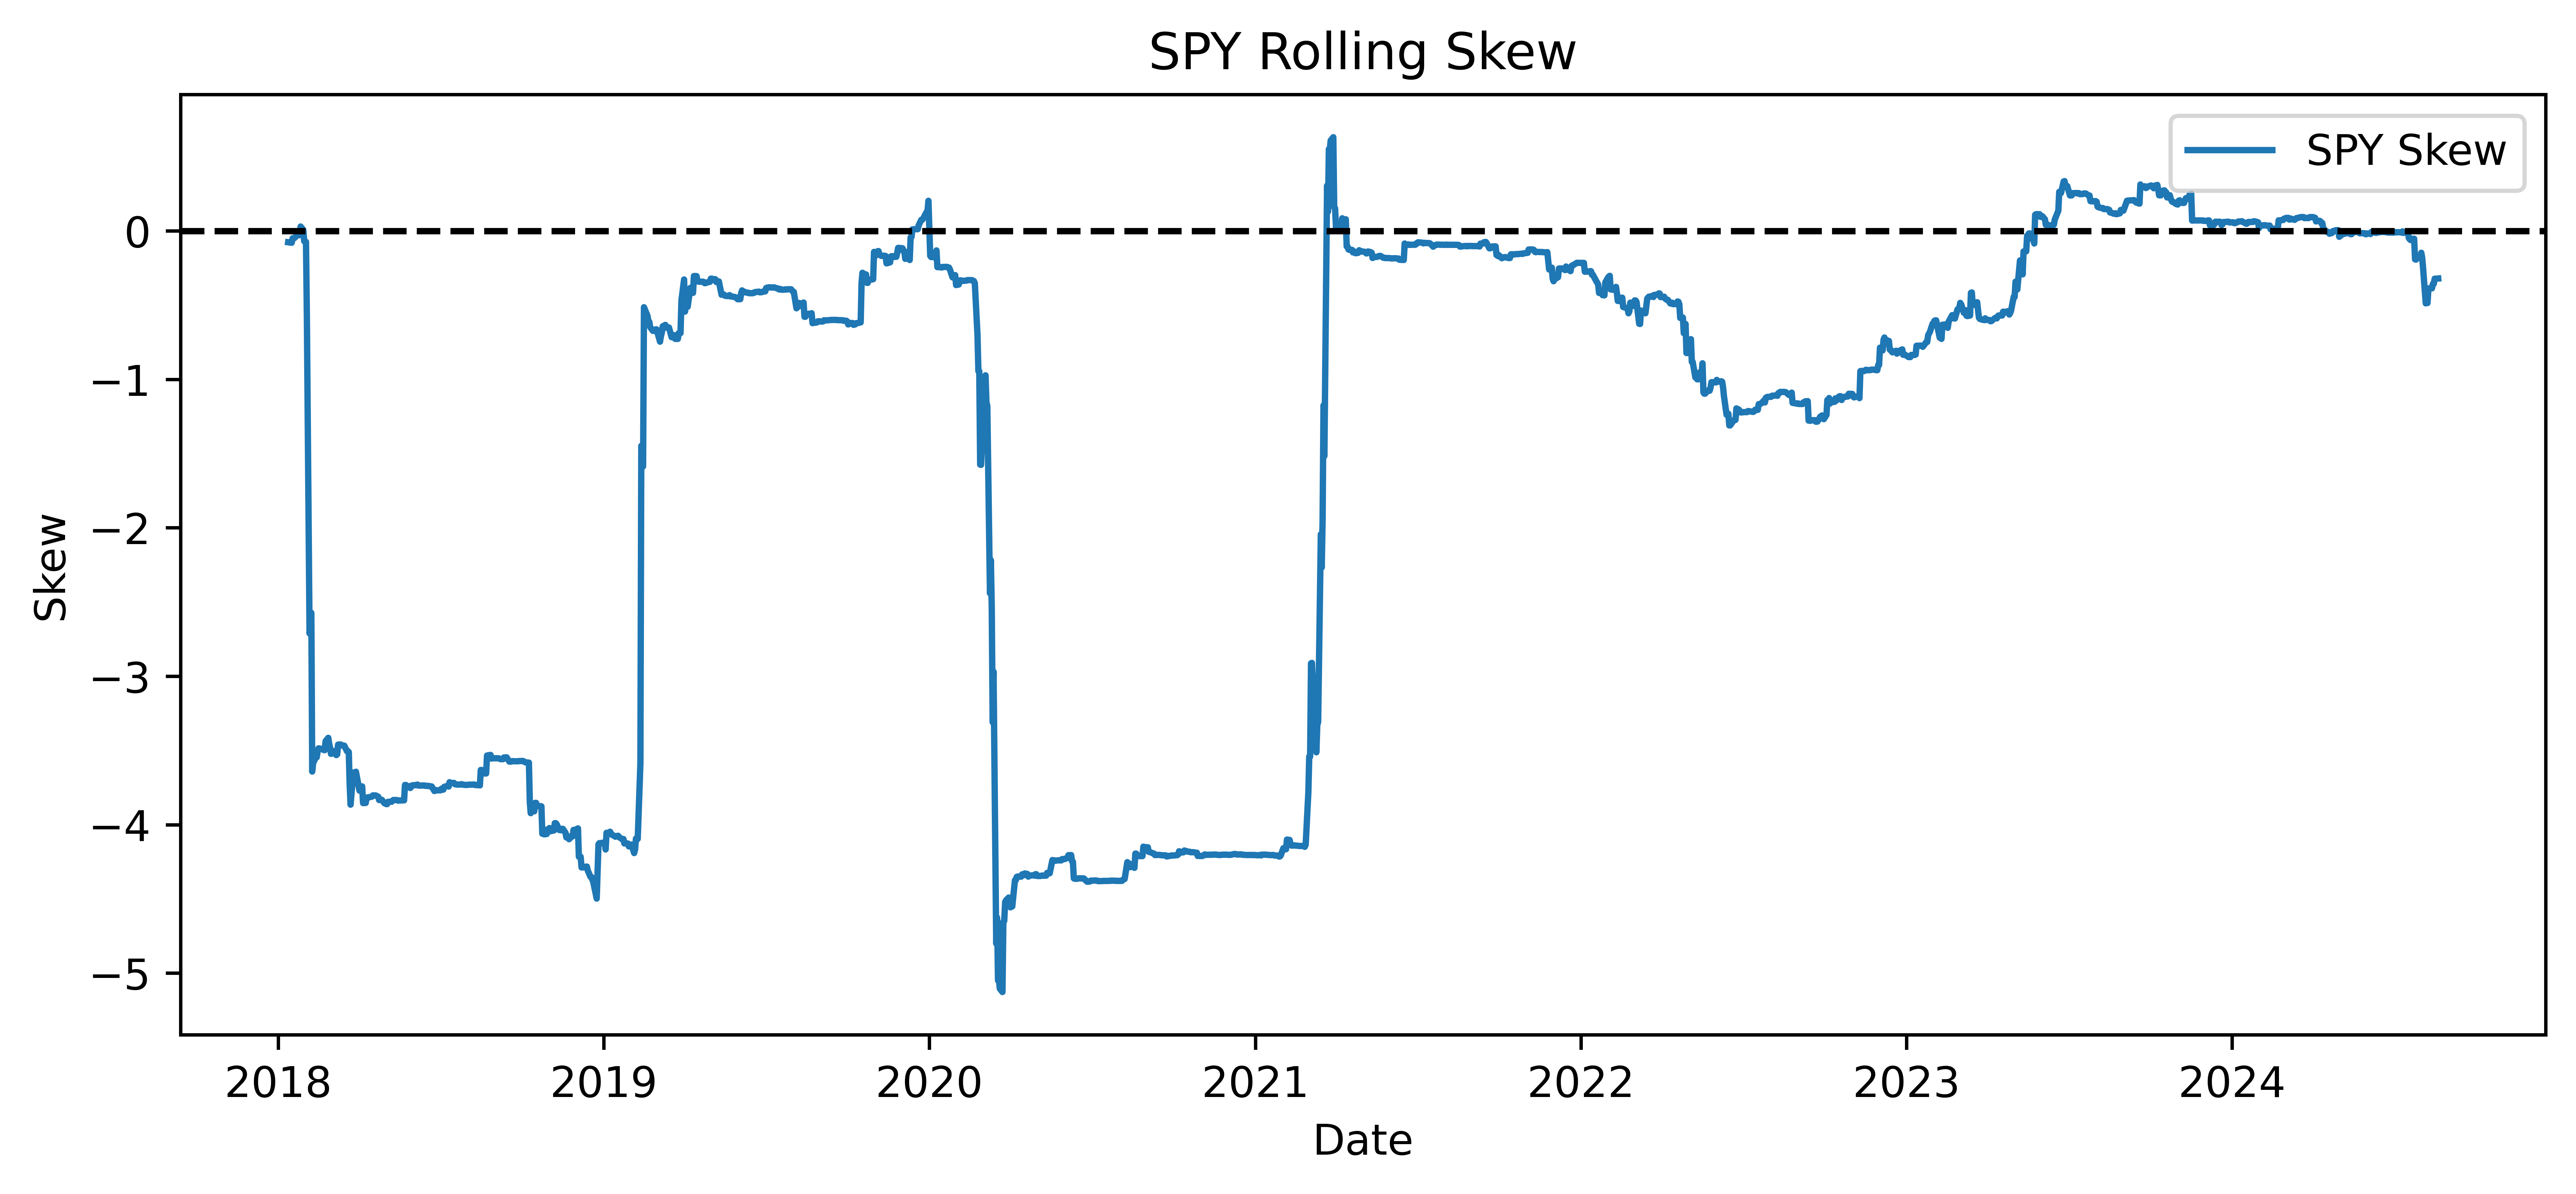

In [41]:
# Plot the results
plt.figure(figsize=(10, 4), dpi=900)
plt.plot(spy['Date'], spy['Skew'], label="SPY Skew")
plt.axhline(y=0, color='black', linestyle='--', label=None)
plt.xlabel("Date")
plt.ylabel("Skew")
plt.title("SPY Rolling Skew")
plt.legend()
plt.show()

It’s jumpy, but the jumps make sense as it’s a third power calculation, so large values will be amplified. SPY became very negatively skewed over COVID-19 as there were all the market corrections leading to large down days. In recent days it’s now more positively skewed as we’ve seen some larger positive returns.

In [42]:
# Define the universe of assets
universe = [
    ("Equity", ["SPY", "EWU", "EWJ", "INDA", "EWG", "EWL", "EWP", "EWQ", 
                "VTI", "FXI", "EWZ", "EWY", "EWA", "EWC", "EWG",
                "EWH", "EWI", "EWN", "EWD", "EWT", "EZA", "EWW", "ENOR", "EDEN", "TUR"]),
    ("FI", ["AGG", "TLT", "LQD", "JNK", "MUB", "MBB", "IAGG", "IGOV", "EMB", 
            "BND", "BNDX", "VCIT", "VCSH", "BSV", "SRLN"]),
    ("Commodities", ["GLD", "SLV", "GSG", "USO", "PPLT", "UNG", "DBA"]),
    ("Other", ["IYR", "REET", "USRT", "ICF", "VNQ"]),
    ("Ccy", ["UUP", "FXY", "FXE", "FXF", "FXB", "FXA", "FXC"])
]

In [43]:
results = {}

for category, tickers in universe:
    category_results = {}
    for ticker in tickers:
        try:
            # Load the ETF data
            df = load(ticker)
            
            # Calculate rolling mean and stddev for LogReturn
            df['Avg'] = df['LogReturn'].rolling(window=256).mean()
            df['Dev'] = df['LogReturn'].rolling(window=256).std()

            # Calculate skewness
            df['SkewDay'] = ((df['LogReturn'] - df['Avg']) / df['Dev']) ** 3
            df['Skew'] = df['SkewDay'].rolling(window=256).mean()

            # Drop NaN values
            df = df.dropna(subset=['Skew'])

            # Store the result
            category_results[ticker] = df

        except Exception as e:
            print(f"Error processing {ticker}: {e}")
    
    results[category] = category_results

# Example: Access SPY data
spy_data = results['Equity']['SPY']
print(spy_data.head())

           Date Ticker   close    open  NextOpen  LogReturn       Avg  \
511  2018-01-12    SPY  250.72  249.34    251.99   0.006683  0.000862   
512  2018-01-16    SPY  249.92  251.99    250.80  -0.003196  0.000862   
513  2018-01-17    SPY  252.22  250.80    252.10   0.009161  0.000898   
514  2018-01-18    SPY  251.83  252.10    252.39  -0.001547  0.000883   
515  2018-01-19    SPY  252.93  252.39    252.73   0.004359  0.000908   

          Dev   SkewDay      Skew  
511  0.004162  2.737088 -0.075093  
512  0.004162 -0.927037 -0.078328  
513  0.004193  7.651106 -0.048439  
514  0.004195 -0.194405 -0.049246  
515  0.004196  0.556032 -0.046902  


In [44]:
# Initialize an empty list to hold the data for all asset classes
all_data_raw = []

# Iterate over the universe to load data for each asset class and its ETFs
for asset_class, etfs in universe:
    print(asset_class)
    
    # Initialize a list to hold DataFrames for each ETF in the asset class
    resdf = []
    
    for etf in etfs:
        # Load data for the ETF
        df = load(etf)
        
        # Append the DataFrame to the list
        resdf.append(df)
    
    # Concatenate all DataFrames in resdf into a single DataFrame for the asset class
    resdf_c = pd.concat(resdf, ignore_index=True)
    
    # Add a new column to indicate the asset class
    resdf_c['AssetClass'] = asset_class
    
    # Append the resulting DataFrame to all_data_raw
    all_data_raw.append(resdf_c)

# Concatenate all asset class DataFrames into a single DataFrame
all_data = pd.concat(all_data_raw, ignore_index=True)

Equity
FI
Commodities
Other
Ccy


In [45]:
# Group the DataFrame by Ticker
grouped = all_data.groupby('Ticker')

# Function to apply rolling calculations to each group
def apply_rolling_calculations(df):
    df['Avg'] = df['LogReturn'].rolling(window=256).mean()
    df['Dev'] = df['LogReturn'].rolling(window=256).std()
    df['SkewDay'] = ((df['LogReturn'] - df['Avg']) / df['Dev']) ** 3
    df['Skew'] = df['SkewDay'].rolling(window=256).mean()
    return df.dropna(subset=['Skew'])  # Drop rows where Skew is NaN

# Apply the rolling calculations to each group and combine the results
all_data = grouped.apply(apply_rolling_calculations).reset_index(drop=True)

logging + check (returns and skew)

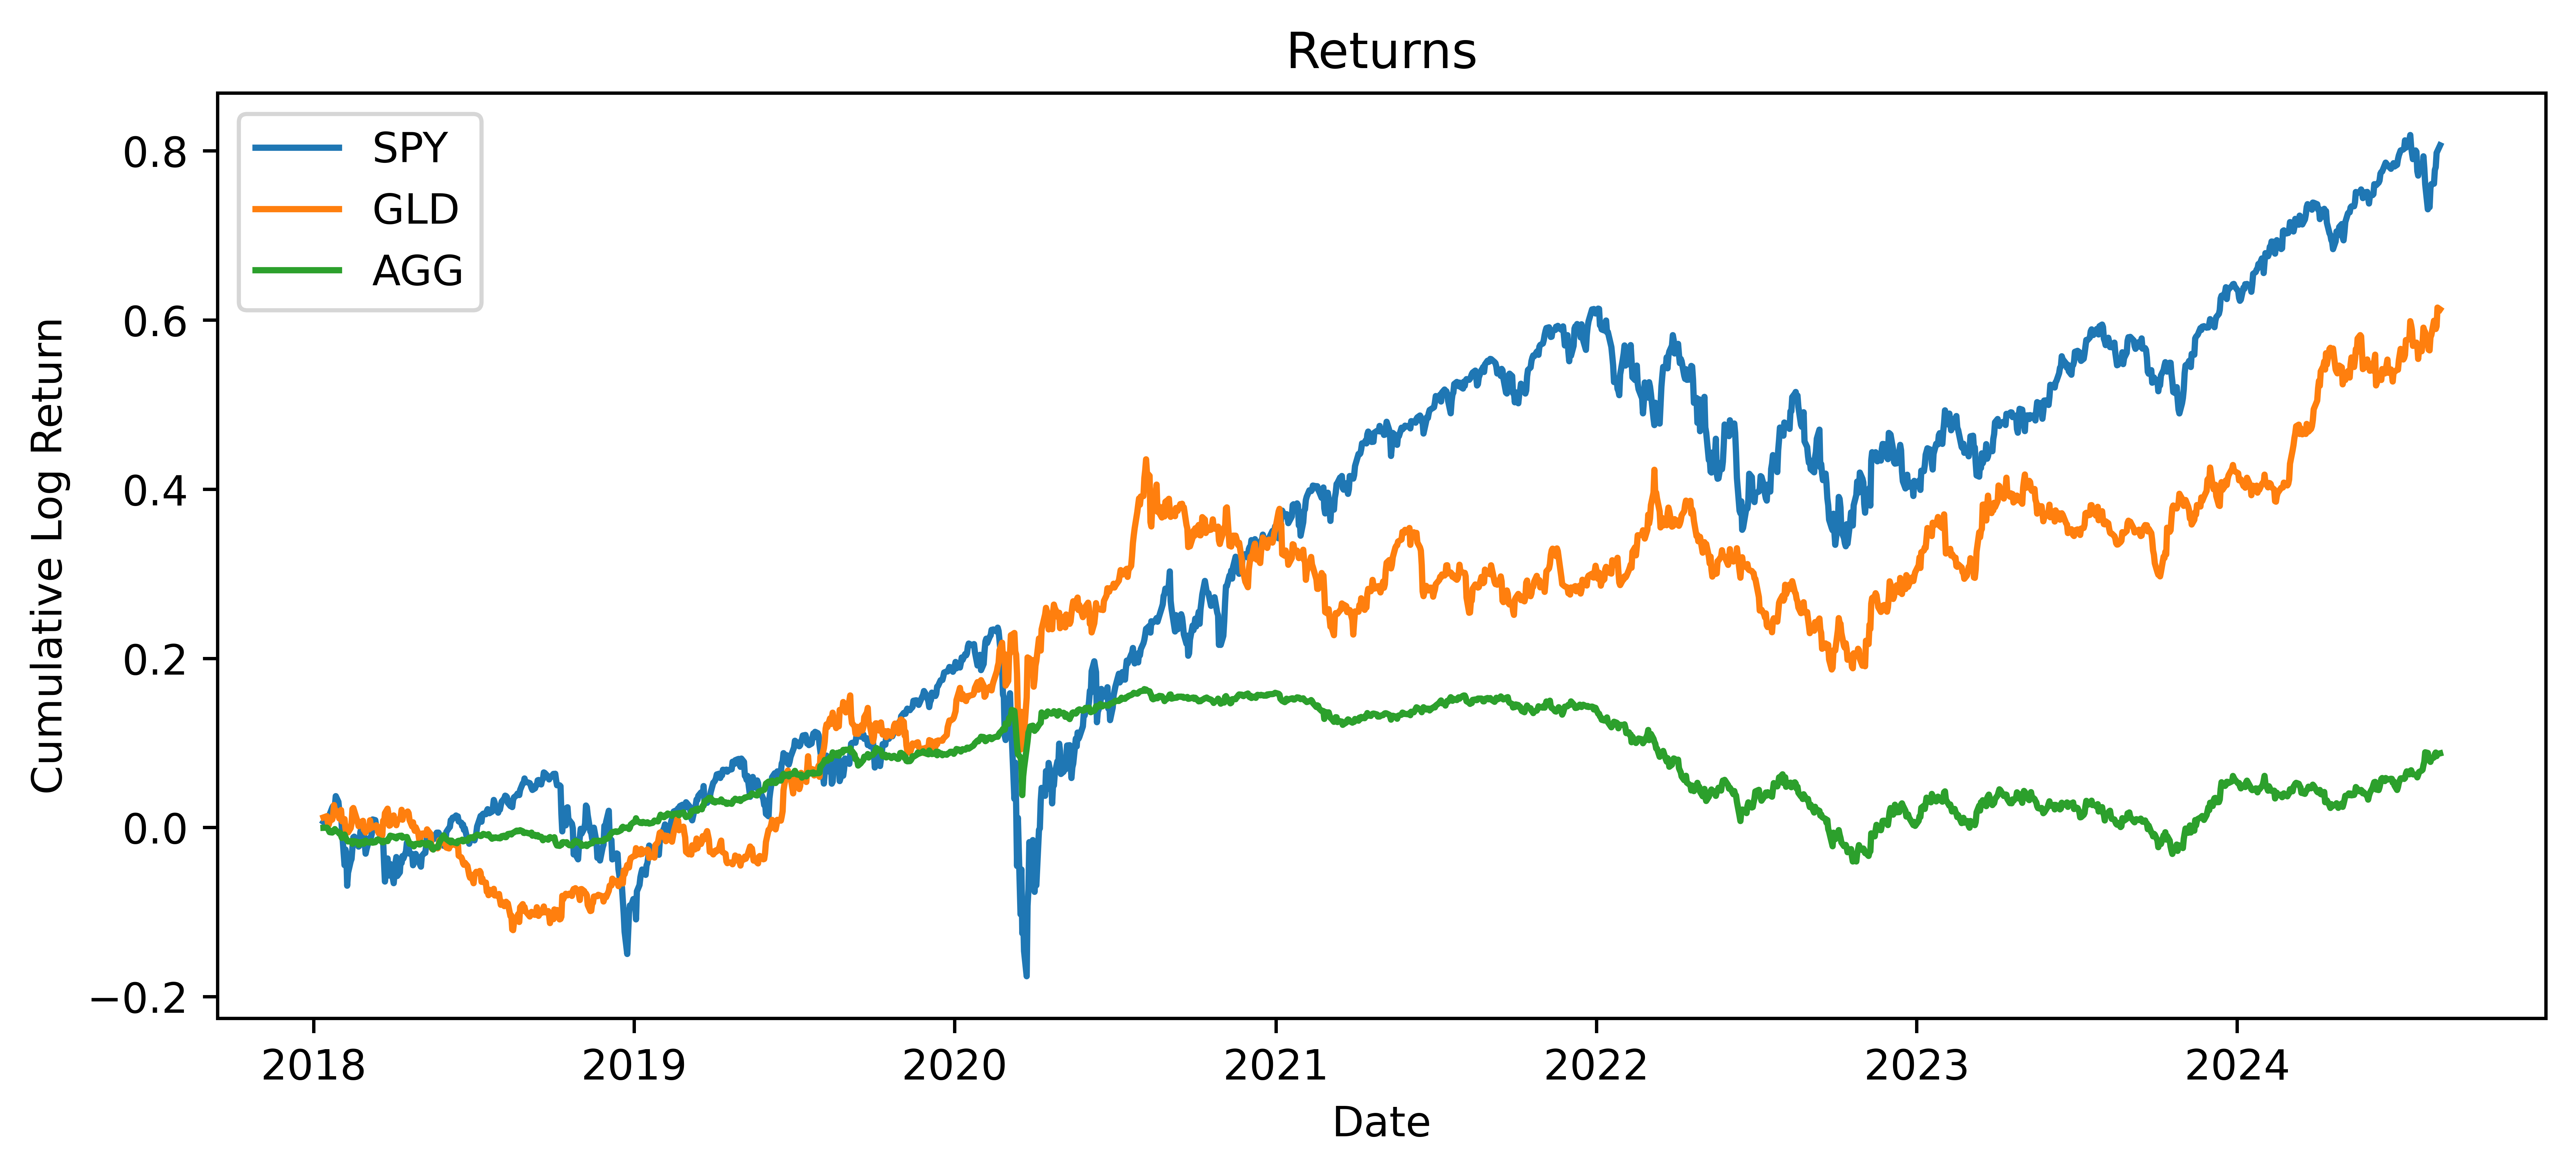

In [46]:
# Filter the data for SPY, GLD, and AGG
spy_data = all_data[all_data['Ticker'] == "SPY"]
gld_data = all_data[all_data['Ticker'] == "GLD"]
agg_data = all_data[all_data['Ticker'] == "AGG"]

# Plot cumulative sum of LogReturn for SPY
plt.figure(figsize=(10, 4), dpi=900)
plt.plot(spy_data['Date'], spy_data['LogReturn'].cumsum(), label="SPY")

# Plot cumulative sum of LogReturn for GLD
plt.plot(gld_data['Date'], gld_data['LogReturn'].cumsum(), label="GLD")

# Plot cumulative sum of LogReturn for AGG
plt.plot(agg_data['Date'], agg_data['LogReturn'].cumsum(), label="AGG")

# Add title and labels
plt.title("Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")

# Display the legend
plt.legend()

# Show the plot
plt.show()

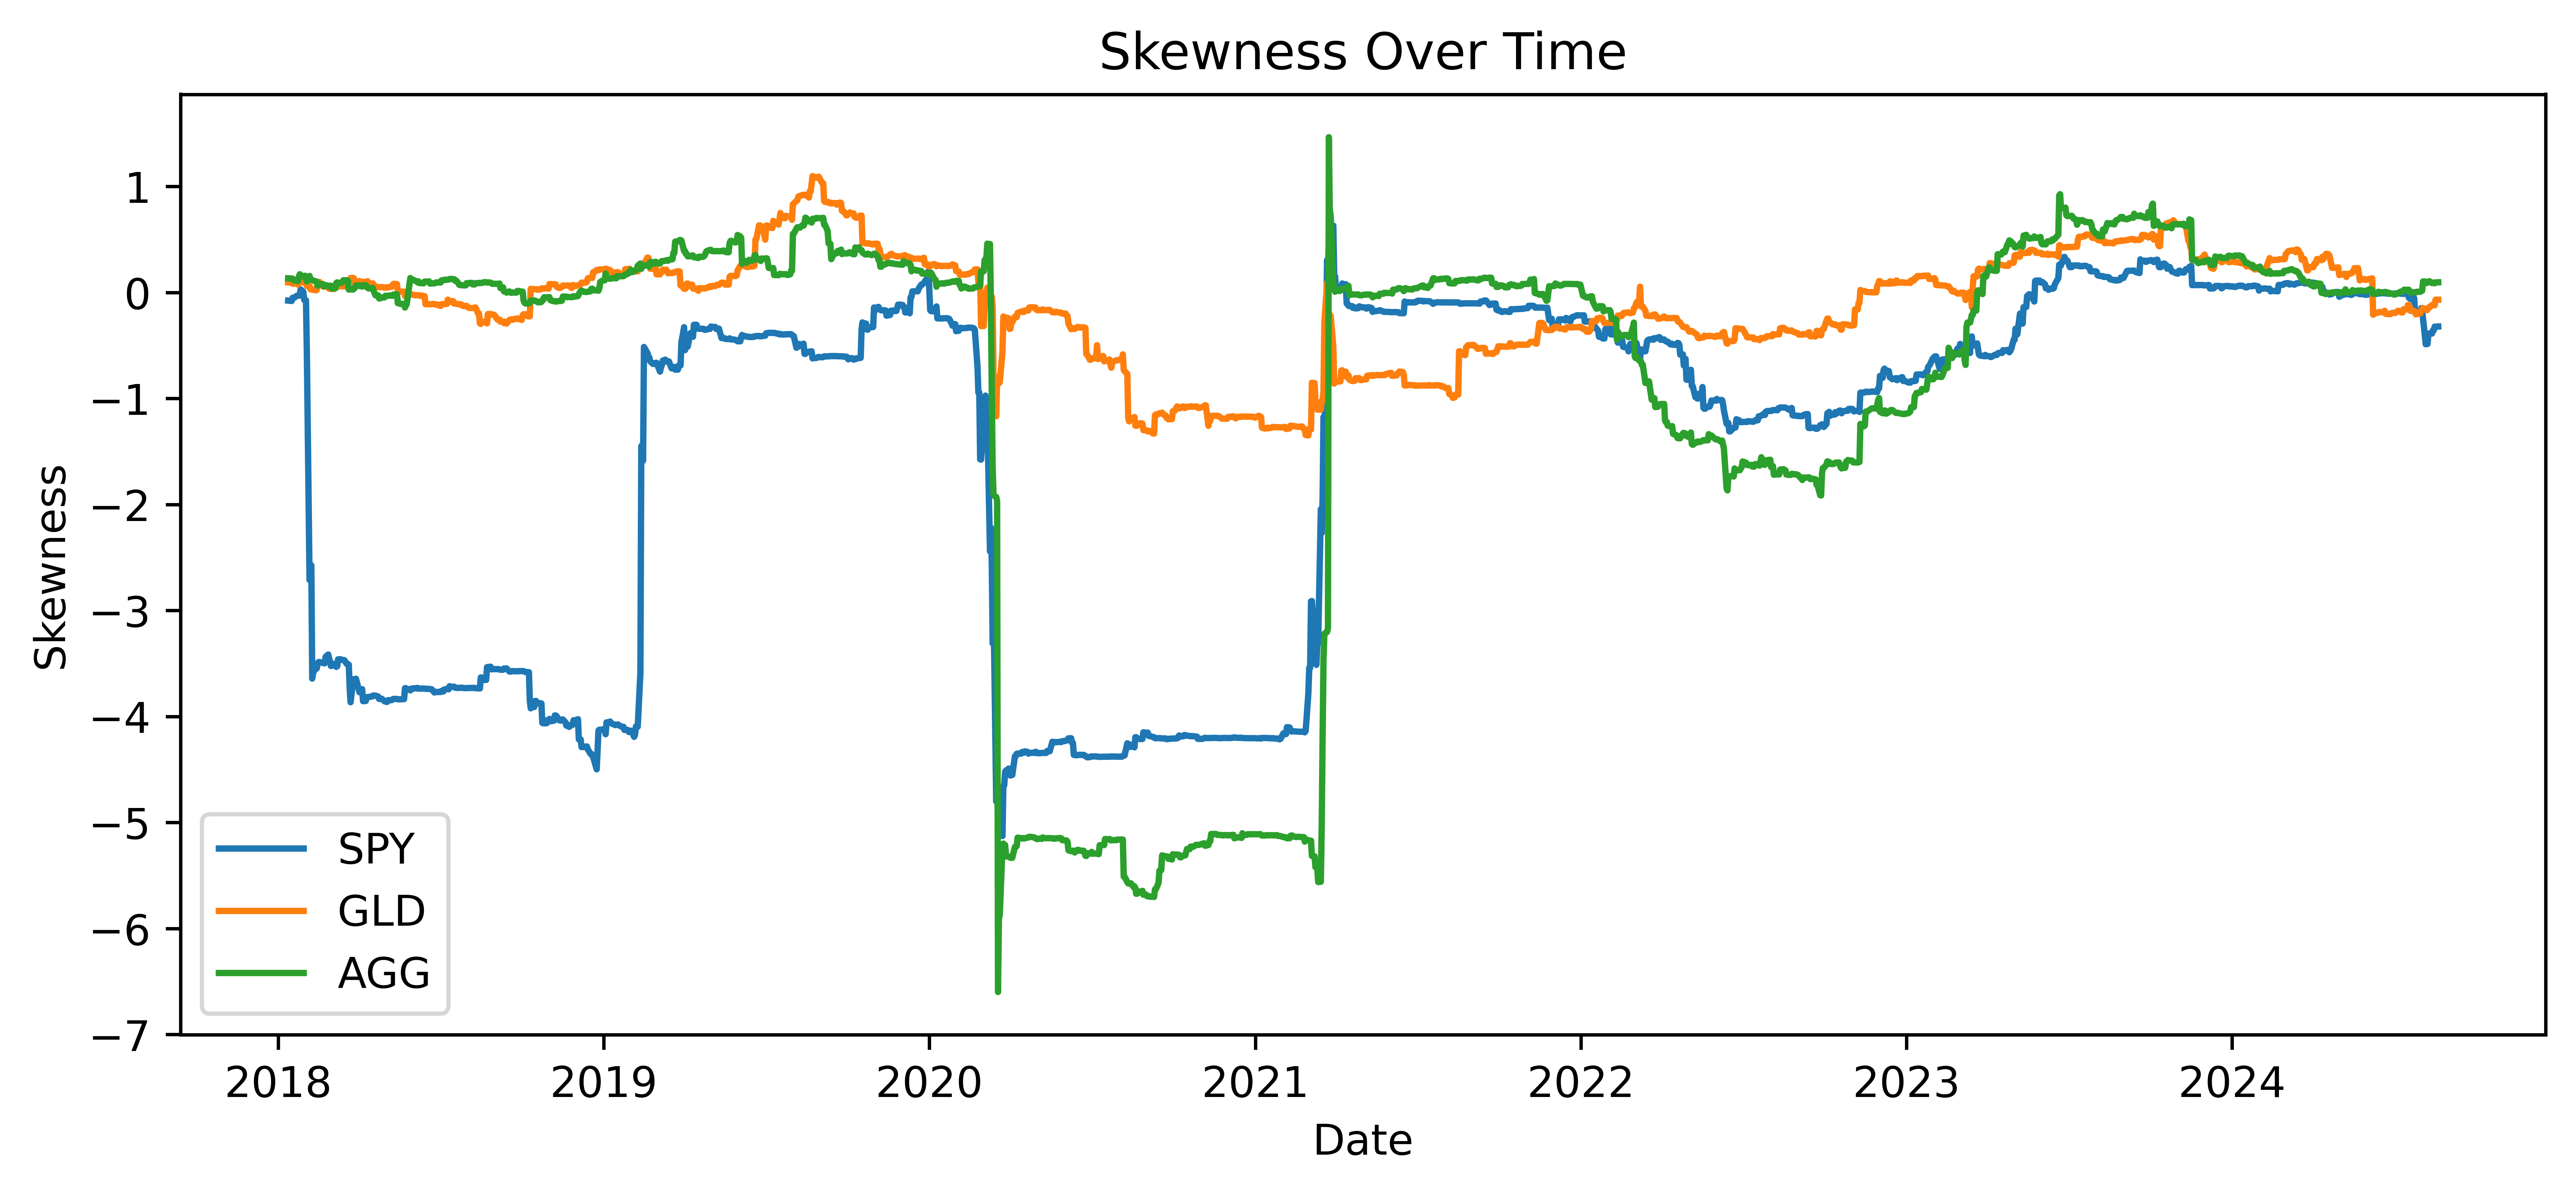

In [47]:
# Filter the data for SPY, GLD, and AGG
spy_data = all_data[all_data['Ticker'] == "SPY"]
gld_data = all_data[all_data['Ticker'] == "GLD"]
agg_data = all_data[all_data['Ticker'] == "AGG"]

# Plot skewness for SPY
plt.figure(figsize=(10, 4), dpi=900)
plt.plot(spy_data['Date'], spy_data['Skew'], label="SPY")

# Plot skewness for GLD
plt.plot(gld_data['Date'], gld_data['Skew'], label="GLD")

# Plot skewness for AGG
plt.plot(agg_data['Date'], agg_data['Skew'], label="AGG")

# Add title and labels
plt.title("Skewness Over Time")
plt.xlabel("Date")
plt.ylabel("Skewness")

# Display the legend
plt.legend()

# Show the plot
plt.show()

### building the backtest

In [48]:
# Ensure the 'Date' column is in datetime format
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Add 'Month' and 'Week' columns by flooring the 'Date' to the beginning of the respective periods
all_data['Month'] = all_data['Date'].dt.to_period('M').dt.to_timestamp()
all_data['Week'] = all_data['Date'].dt.to_period('W-SUN').dt.to_timestamp()

# Calculate the next trading day for each ticker
all_data['NextDay'] = all_data.groupby('Ticker')['Date'].shift(-1)

# Set a placeholder date far in the future to fill in the last 'NextDay' entry for each group (similar to Date(2015) in Julia)
future_date = pd.Timestamp('2015-01-01')
all_data['NextDay'].fillna(future_date, inplace=True)

# Group by Month, AssetClass, and Ticker to get the end-of-month values
monthly_vals = all_data.groupby(['Month', 'AssetClass', 'Ticker']).agg(
    Date=('Date', 'last'),         # Get the last date of the month
    NextDate=('NextDay', 'last'),  # Get the first trading day of the next month
    EOMSkew=('Skew', 'last')       # Get the last skew value of the month
).reset_index()

In [49]:
monthly_vals.head()

Month AssetClass Ticker       Date   NextDate   EOMSkew
0 2018-01-01        Ccy    FXA 2018-01-31 2018-02-01  0.197966
1 2018-01-01        Ccy    FXB 2018-01-31 2018-02-01  0.320188
2 2018-01-01        Ccy    FXC 2018-01-31 2018-02-01  0.463590
3 2018-01-01        Ccy    FXE 2018-01-31 2018-02-01  0.511012
4 2018-01-01        Ccy    FXF 2018-01-31 2018-02-01  0.274656

In [50]:
# Group by Date and AssetClass to rank assets within each group
monthly_vals['SkewWeightRaw'] = monthly_vals.groupby(['Date', 'AssetClass'])['EOMSkew'].transform(
    lambda x: x.rank(ascending=False) - ((len(x) + 1) / 2)
)

# Normalize the SkewWeightRaw to get SkewWeight (so that long positions sum to 1 and short positions sum to -1)
def normalize_weights(x):
    max_weight = x['SkewWeightRaw'].abs().max()
    return x['SkewWeightRaw'] / (x['SkewWeightRaw'].abs().sum() / 2)

monthly_vals['SkewWeight'] = monthly_vals.groupby(['Date', 'AssetClass']).apply(normalize_weights).reset_index(drop=True)

monthly_vals.head()

Month AssetClass Ticker       Date   NextDate   EOMSkew  SkewWeightRaw  \
0 2018-01-01        Ccy    FXA 2018-01-31 2018-02-01  0.197966            1.0   
1 2018-01-01        Ccy    FXB 2018-01-31 2018-02-01  0.320188           -1.0   
2 2018-01-01        Ccy    FXC 2018-01-31 2018-02-01  0.463590           -2.0   
3 2018-01-01        Ccy    FXE 2018-01-31 2018-02-01  0.511012           -3.0   
4 2018-01-01        Ccy    FXF 2018-01-31 2018-02-01  0.274656            0.0   

   SkewWeight  
0    0.166667  
1   -0.166667  
2   -0.333333  
3   -0.500000  
4    0.000000

Commodity ETFs - Latest Skew Values and Portfolio Weights
     Ticker   EOMSkew  SkewWeight
4549    DBA -0.870153    0.500000
4550    GLD -0.066628    0.000000
4551    GSG -0.142223    0.166667
4552   PPLT  0.080191   -0.333333
4553    SLV  0.160108   -0.500000
4554    UNG -0.033371   -0.166667
4555    USO -0.152382    0.333333


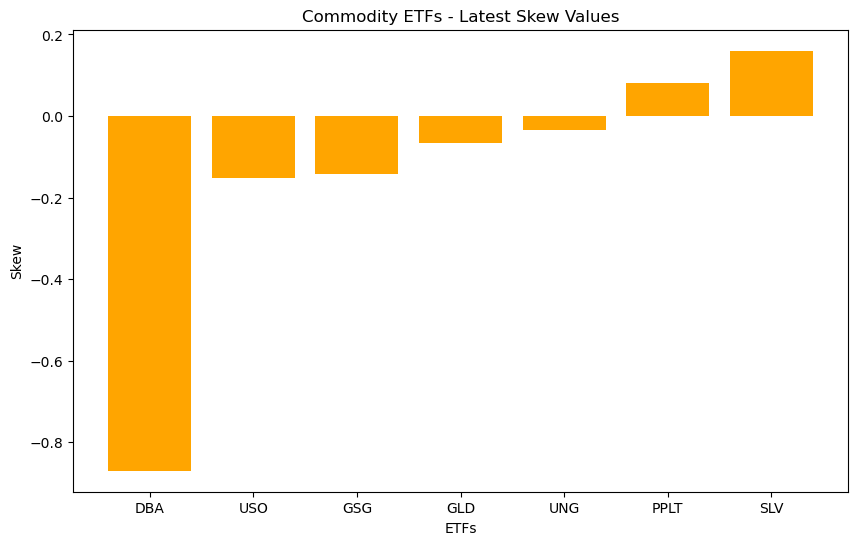

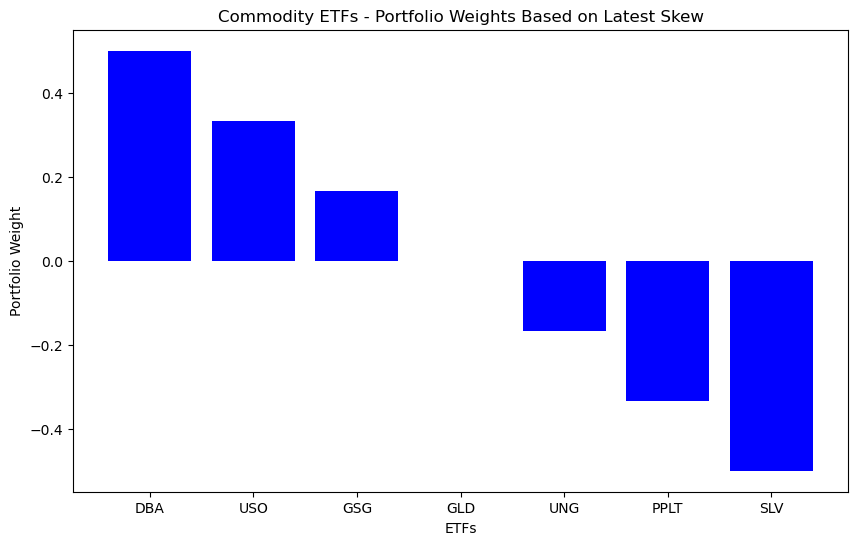

In [51]:
# Filter the data to get the latest skew values for Commodity ETFs
latest_date = monthly_vals['Date'].max()
commodity_etfs = monthly_vals[(monthly_vals['AssetClass'] == 'Commodities') & (monthly_vals['Date'] == latest_date)]

# Display the latest skew values and corresponding portfolio weights
print("Commodity ETFs - Latest Skew Values and Portfolio Weights")
print(commodity_etfs[['Ticker', 'EOMSkew', 'SkewWeight']])

# Visualize the relationship between skew values and portfolio weights
commodity_etfs_sorted = commodity_etfs.sort_values('EOMSkew')

# Plot Skew values
plt.figure(figsize=(10, 6))
plt.bar(commodity_etfs_sorted['Ticker'], commodity_etfs_sorted['EOMSkew'], color='orange')
plt.title('Commodity ETFs - Latest Skew Values')
plt.xlabel('ETFs')
plt.ylabel('Skew')
plt.show()

# Plot Portfolio Weights
plt.figure(figsize=(10, 6))
plt.bar(commodity_etfs_sorted['Ticker'], commodity_etfs_sorted['SkewWeight'], color='blue')
plt.title('Commodity ETFs - Portfolio Weights Based on Latest Skew')
plt.xlabel('ETFs')
plt.ylabel('Portfolio Weight')
plt.show()

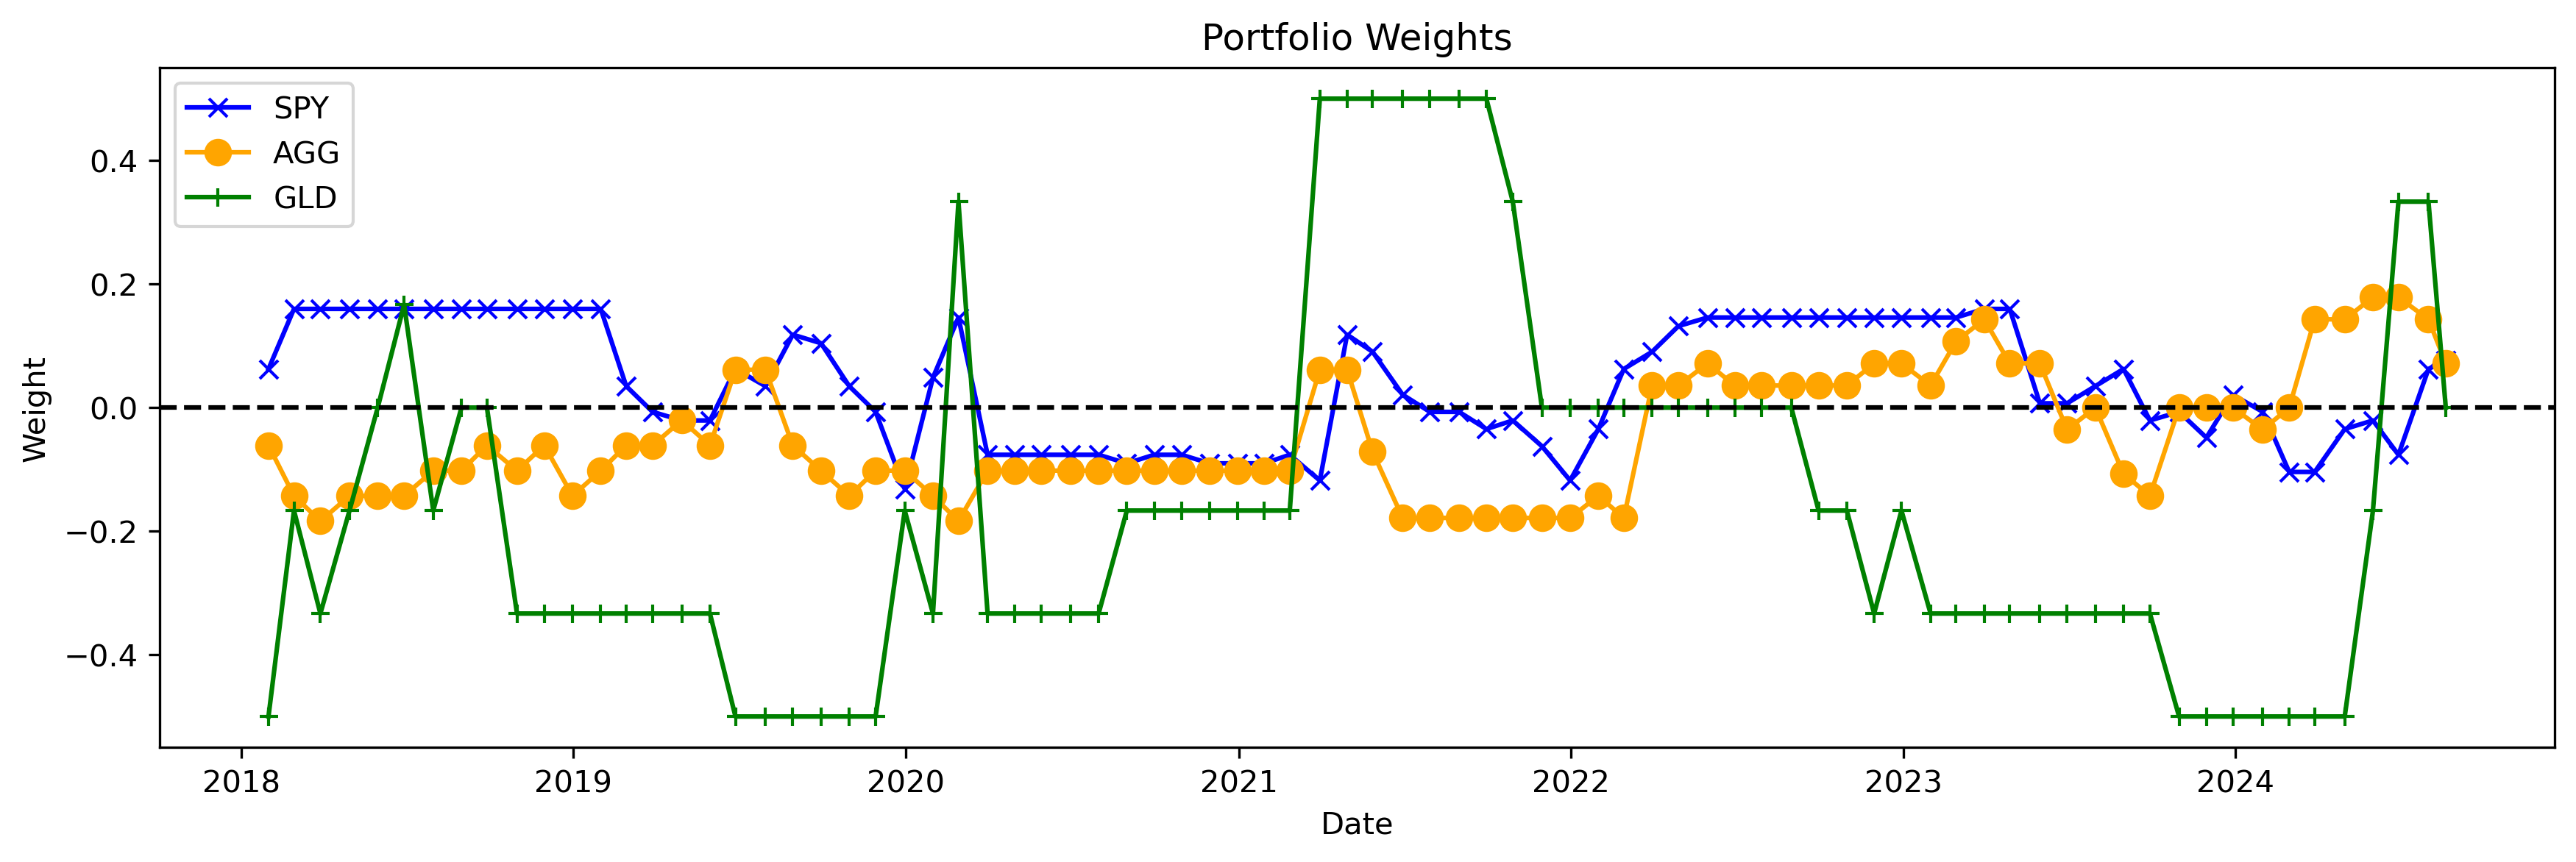

In [53]:
# Filter the data for the three sample assets
spy_data = monthly_vals[monthly_vals['Ticker'] == "SPY"]
agg_data = monthly_vals[monthly_vals['Ticker'] == "AGG"]
gld_data = monthly_vals[monthly_vals['Ticker'] == "GLD"]

plt.figure(figsize=(14, 4), dpi=300)
plt.plot(spy_data['Date'], spy_data['SkewWeight'], label="SPY", color="blue", marker='x', linestyle='-', markersize=6)
plt.plot(agg_data['Date'], agg_data['SkewWeight'], label="AGG", color="orange", marker='o', linestyle='-', markersize=8)
plt.plot(gld_data['Date'], gld_data['SkewWeight'], label="GLD", color="green", marker='+', linestyle='-', markersize=6)
plt.axhline(y=0, color='black', linestyle='--')

plt.title("Portfolio Weights")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.legend()
plt.show()

In [55]:
# Define the forward fill function
def ffill(v):
    # Create a boolean mask where values are non-missing (not NaN)
    mask = ~v.isna()
    # Use accumulate with numpy's maximum to propagate the last valid index
    ffill_indices = np.maximum.accumulate(np.where(mask, np.arange(len(v)), 0))
    # Forward fill by indexing
    return v.iloc[ffill_indices]

# Select relevant columns from monthlyVals and rename NextDate to Date
weightings = monthly_vals[['NextDate', 'Ticker', 'SkewWeight']].rename(columns={'NextDate': 'Date'})

# Perform a left join with the original all_data dataframe
all_data_weights = pd.merge(all_data, weightings, on=['Date', 'Ticker'], how='left')

# Sort by Date
all_data_weights = all_data_weights.sort_values(by='Date')

# Forward fill SkewWeight within each Ticker group
all_data_weights['SkewWeight2'] = all_data_weights.groupby('Ticker')['SkewWeight'].apply(ffill).reset_index(drop=True)

# Ensure the index alignment by resetting the index after the groupby apply operation
all_data_weights['SkewWeight2'] = all_data_weights['SkewWeight2'].values

# Example: Show the first few rows of the result
print(all_data_weights.head())

            Date Ticker  close   open  NextOpen  LogReturn AssetClass  \
0     2018-01-12    AGG  91.76  91.67     91.87  -0.000218         FI   
61420 2018-01-12   IGOV  49.95  49.61     50.15   0.009858         FI   
63080 2018-01-12   INDA  33.98  33.87     33.66   0.002062     Equity   
64740 2018-01-12    IYR  63.97  64.36     64.21  -0.007941      Other   
9960  2018-01-12    EMB  85.44  85.18     85.47   0.001405         FI   

            Avg       Dev    SkewDay      Skew      Month       Week  \
0      0.000111  0.001696  -0.007269  0.135084 2018-01-01 2018-01-08   
61420  0.000489  0.004305  10.309112  0.215690 2018-01-01 2018-01-08   
63080  0.001273  0.008177   0.000899 -0.121994 2018-01-01 2018-01-08   
64740  0.000076  0.005867  -2.551237 -0.319008 2018-01-01 2018-01-08   
9960   0.000318  0.002592   0.073959  0.004401 2018-01-01 2018-01-08   

         NextDay  SkewWeight  SkewWeight2  
0     2018-01-16         NaN          NaN  
61420 2018-01-16         NaN          Na

### Plotting returns for skew portfolios

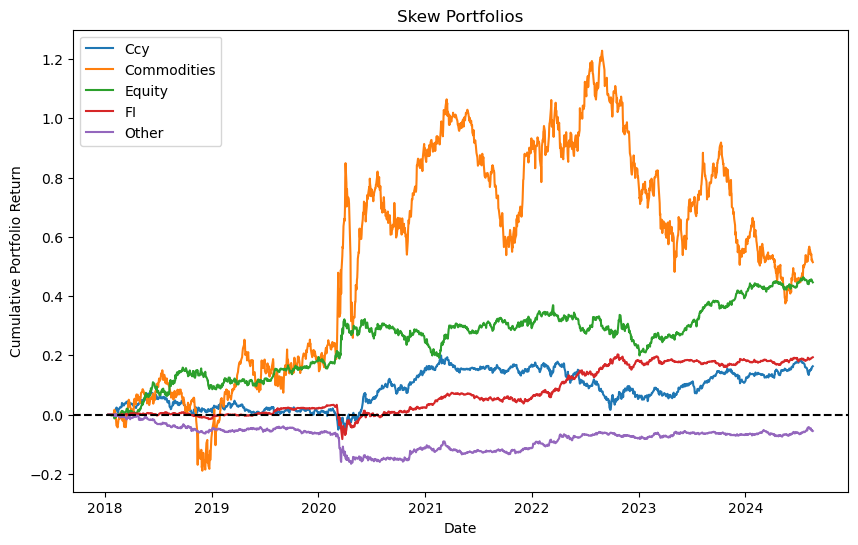

In [56]:
# Group by Date and AssetClass, calculate PortfolioReturn and MktReturn
asset_portfolios = all_data_weights.groupby(['Date', 'AssetClass']).agg(
    PortfolioReturn=pd.NamedAgg(column='SkewWeight2', aggfunc=lambda x: (x * all_data_weights.loc[x.index, 'LogReturn']).sum()),
    MktReturn=pd.NamedAgg(column='LogReturn', aggfunc='mean')
).reset_index()

# Drop any rows with missing values
asset_portfolios = asset_portfolios.dropna()

# Plotting the results
plt.figure(figsize=(10, 6))
plt.title("Skew Portfolios")

# Loop over each AssetClass to plot its cumulative PortfolioReturn
for ac in asset_portfolios['AssetClass'].unique():
    ac_data = asset_portfolios[asset_portfolios['AssetClass'] == ac]
    plt.plot(ac_data['Date'], ac_data['PortfolioReturn'].cumsum(), label=ac)

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--')

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Cumulative Portfolio Return")
plt.legend()

# Show the plot
plt.show()

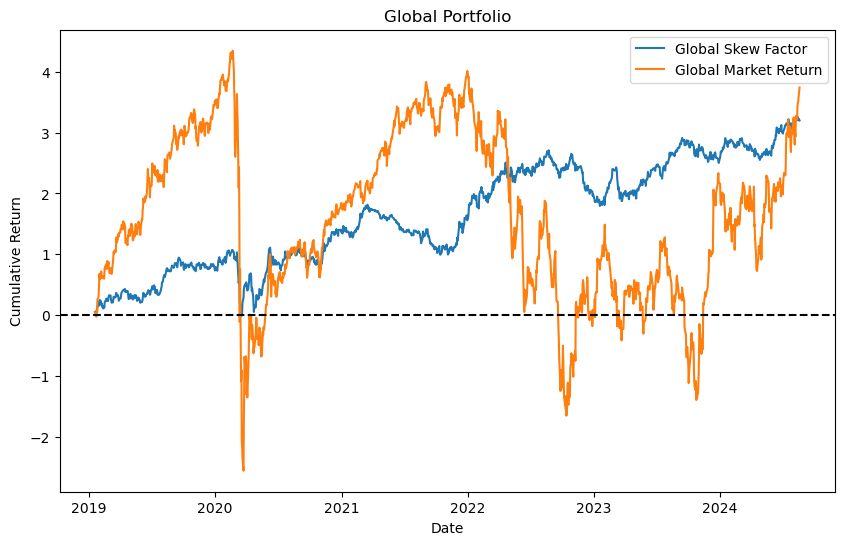

In [57]:
# Calculate rolling volatility (256-day rolling standard deviation) within each AssetClass
asset_portfolios['Vol'] = asset_portfolios.groupby('AssetClass')['PortfolioReturn'].transform(lambda x: x.rolling(window=256).std())

# Normalize the returns by their volatility
asset_portfolios['NormReturn'] = 0.1 * asset_portfolios['PortfolioReturn'] / asset_portfolios['Vol']
asset_portfolios['NormMarketReturn'] = 0.1 * asset_portfolios['MktReturn'] / asset_portfolios['Vol']

# Group by Date to calculate the global skew factor and global market return
gcf = asset_portfolios.groupby('Date').agg(
    Return=pd.NamedAgg(column='NormReturn', aggfunc='mean'),
    MktReturn=pd.NamedAgg(column='NormMarketReturn', aggfunc='mean')
).reset_index()

# Plotting the Global Portfolio Returns
plt.figure(figsize=(10, 6))
plt.title("Global Portfolio")

# Plot cumulative Global Skew Factor returns
plt.plot(gcf['Date'].iloc[1:], gcf['Return'].iloc[1:].cumsum(), label="Global Skew Factor")

# Plot cumulative Global Market returns
plt.plot(gcf['Date'].iloc[1:], gcf['MktReturn'].iloc[1:].cumsum(), label="Global Market Return")

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--')

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()

# Show the plot
plt.show()

### Alpha vs Beta (vs a mysterious third thing)

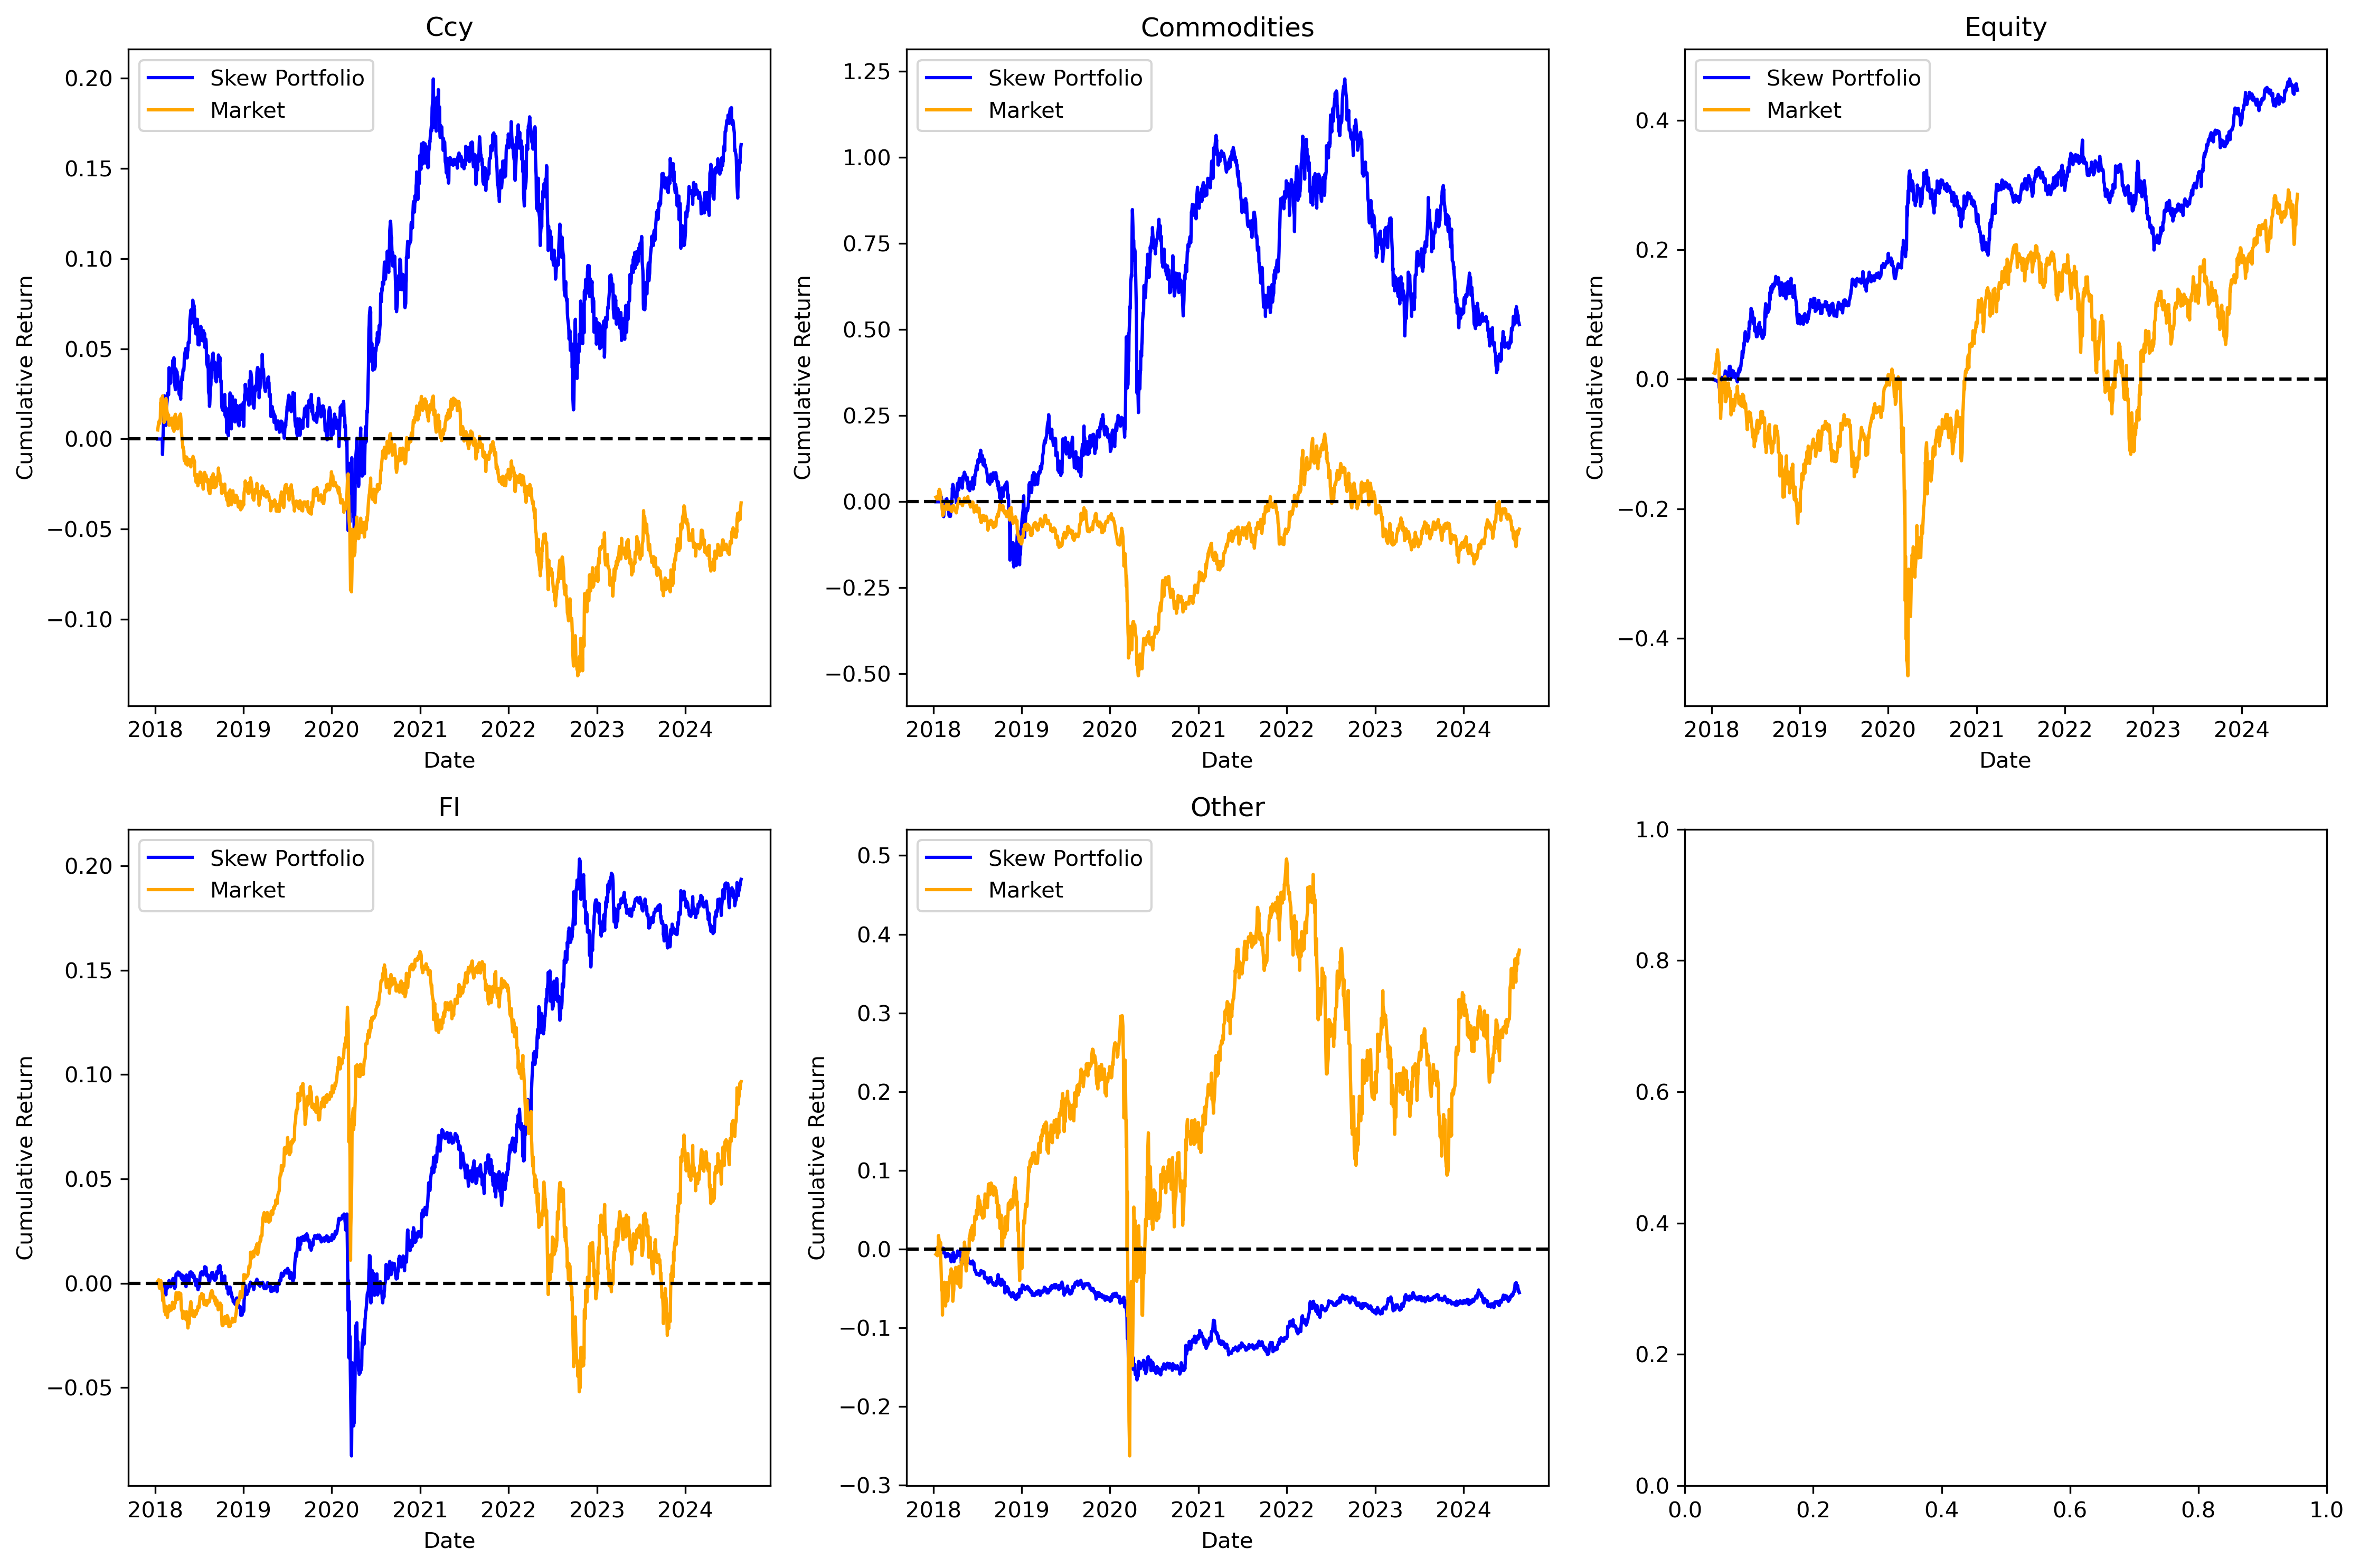

In [58]:
# Set up a 2x3 grid for the plots (adjust based on the number of asset classes)
fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=300)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over each asset class and plot the results
for i, asset_class in enumerate(asset_portfolios['AssetClass'].unique()):
    # Filter data for the current asset class
    ac_data = asset_portfolios[asset_portfolios['AssetClass'] == asset_class]
    
    # Plot cumulative returns for the Skew Portfolio
    axes[i].plot(ac_data['Date'], ac_data['PortfolioReturn'].cumsum(), label="Skew Portfolio", color='blue')
    
    # Plot cumulative returns for the Market
    axes[i].plot(ac_data['Date'], ac_data['MktReturn'].cumsum(), label="Market", color='orange')
    
    # Add a horizontal line at y=0
    axes[i].axhline(y=0, color='black', linestyle='--')
    
    # Set the title to the asset class
    axes[i].set_title(asset_class)
    
    # Add labels for the x-axis and y-axis
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Cumulative Return")
    
    # Add a legend
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()